In [2]:
! pip install tensorflow-datasets


Defaulting to user installation because normal site-packages is not writeable


In [1]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 666s 1s/step - accuracy: 0.0000e+00 - loss: 0.0771 - val_accuracy: 0.0000e+00 - val_loss: 0.0424 - learning_rate: 0.0010
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 673s 1s/step - accuracy: 0.0000e+00 - loss: 0.0423 - val_accuracy: 0.0000e+00 - val_loss: 0.0424 - learning_rate: 0.0010
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 744s 2s/step - accuracy: 0.0000e+00 - loss: 0.0422 - val_accuracy: 0.0000e+00 - val_loss: 0.0424 - learning_rate: 0.0010
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.0000e+00 - loss: 0.0423 - val_accuracy: 0.0000e+00 - val_loss: 0.0424 - learning_rate: 0.0010
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 567s 1s/step - accuracy: 0.0000e+00 - loss: 0.0423 - val_accuracy: 0.0000e+00 - val_loss: 0.0424 - learning_rate: 2.0000e-04
Epoch 6/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 574s 1s/step - accuracy: 0.0000e+00 - loss: 0.0423 - val_accuracy: 0.0000e+00 - val_loss: 0.0424 - learning_rate: 2.0000e-04
Epoch 7/30
460/460 ━━━━━━━

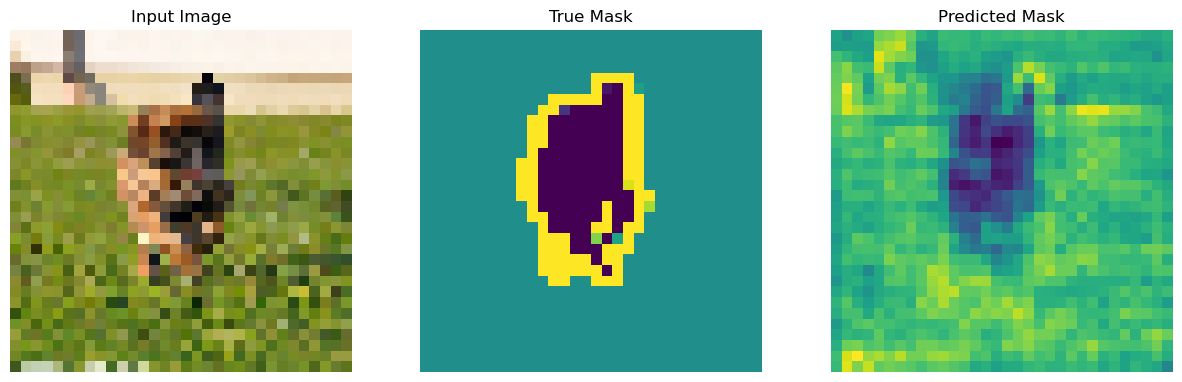

In [2]:
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Параметры модели и данных
BATCH_SIZE = 4
IMG_SIZE = 128  # Увеличим размер до 128x128 для более точных предсказаний
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Функция для нормализации изображений и масок
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) / 255.0
    return input_image, input_mask

# Функция для аугментации данных
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

# Функция для загрузки и предобработки изображения и маски
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))
    input_image, input_mask = normalize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)  # Аугментация данных
    return input_image, input_mask

# Загрузка и предобработка данных
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
train_dataset = dataset['train'].map(load_image, num_parallel_calls=AUTOTUNE)
test_dataset = dataset['test'].map(load_image, num_parallel_calls=AUTOTUNE)

# Настройка пайплайна данных
train_batches = train_dataset.cache().shuffle(1000).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=AUTOTUNE)
test_batches = test_dataset.batch(BATCH_SIZE)

# Функция для создания модели U-Net
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Компиляция модели
model = unet_model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Добавление callback'ов
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Обучение модели
EPOCHS = 30
steps_per_epoch = len(train_dataset) // BATCH_SIZE

history = model.fit(train_batches, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
                    validation_data=test_batches, callbacks=[early_stopping, reduce_lr])

# Функция для визуализации изображений и масок
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in test_batches.take(1):
    pred_mask = model.predict(image)
    display([image[0], mask[0], pred_mask[0]])


Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 1373s 3s/step - accuracy: 0.0000e+00 - loss: 0.0680 - val_accuracy: 0.0000e+00 - val_loss: 0.0425 - learning_rate: 0.0010
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 1297s 3s/step - accuracy: 0.0000e+00 - loss: 0.0423 - val_accuracy: 0.0000e+00 - val_loss: 0.0424 - learning_rate: 0.0010
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 1299s 3s/step - accuracy: 0.0000e+00 - loss: 0.0423 - val_accuracy: 0.0000e+00 - val_loss: 0.0425 - learning_rate: 0.0010
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 1306s 3s/step - accuracy: 0.0000e+00 - loss: 0.0423 - val_accuracy: 0.0000e+00 - val_loss: 0.0423 - learning_rate: 0.0010
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 1310s 3s/step - accuracy: 0.0000e+00 - loss: 0.0422 - val_accuracy: 0.0000e+00 - val_loss: 0.0423 - learning_rate: 0.0010
Epoch 6/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 1298s 3s/step - accuracy: 0.0000e+00 - loss: 0.0422 - val_accuracy: 0.0000e+00 - val_loss: 0.0423 - learning_rate: 0.0010
Epoch 7/30
460/460 ━━━━━━━━━

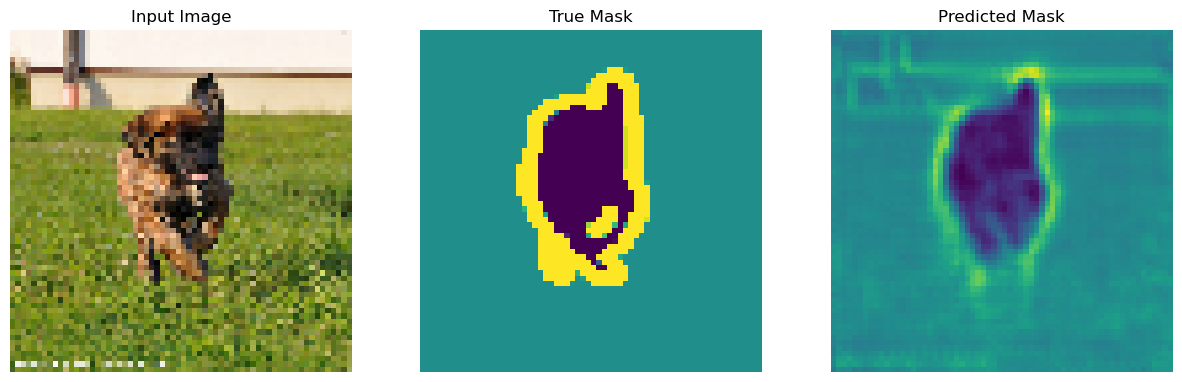

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Параметры модели и данных
BATCH_SIZE = 8
IMG_SIZE = 64  
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Функция для нормализации изображений и масок
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32) / 255.0
    return input_image, input_mask

# Функция для аугментации данных
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

# Функция для загрузки и предобработки изображения и маски
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))
    input_image, input_mask = normalize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)  # Аугментация данных
    return input_image, input_mask

# Загрузка и предобработка данных
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
train_dataset = dataset['train'].map(load_image, num_parallel_calls=AUTOTUNE)
test_dataset = dataset['test'].map(load_image, num_parallel_calls=AUTOTUNE)

# Настройка пайплайна данных
train_batches = train_dataset.cache().shuffle(500).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=AUTOTUNE)
test_batches = test_dataset.batch(BATCH_SIZE)

# Функция для создания модели U-Net
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Компиляция модели
model = unet_model()
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Добавление callback'ов
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Обучение модели
EPOCHS = 30
steps_per_epoch = len(train_dataset) // BATCH_SIZE

history = model.fit(train_batches, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
                    validation_data=test_batches, callbacks=[early_stopping, reduce_lr])

# Функция для визуализации изображений и масок
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in test_batches.take(1):
    pred_mask = model.predict(image)
    display([image[0], mask[0], pred_mask[0]])


Данная модель нейронной сети потребляет много ресурсов, из опытов можно сделать вывод:
- уменьшая разрешения картинки модель перестает обучаться, либо сильно снижает скорость обучения, с учетом быстрой итерацией по батчам. 
- уменьшая количество эпох  в модели приводит к недообучению, что хорошо видно в файлах HW_6_2.ipynb и HW_6_3.ipynb.
- также большой разницы в обучении модели я не увидели при изменении оптимайзера Adam vs RMSprop. 
- из явных ускорителях обучения я бы отметил снижения размеров батчей, которые не сильно влияют на качество модели. 
- для увеличения качества модели я бы рекомендовал увеличение эпох (ведет к увеличению времени на обучения) и увеличение разрешения картинки(при увеличении разрешения вдвое 256х256 моя оперативная память в 8 гб резко уходила в аварию, что говорит о явном увеличение нагрузки на "железо")